# 3ML with Fermi GBM TTE Data
### Purpose
Fermi GBM data is in a format that does not lend itself to being used with standard software such as XSPEC. However, the **FermiGBMLikeTTE** in **3ML** plugin allows the user to work directly with the TTE data in its native format

**FermiGBMLikeTTE** provides the following functionality
* Reading GBM TTE data
* Proper MLE polynomial background fitting
* Pure counts and light curve plotting

It creates a standard **3ML** Model and therefore can be used like any other plugin *without* using specical tools to create PHA files.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin

In [1]:
%matplotlib inline

from threeML import *



get_available_plugins()


WARNING CppInterfaceNotAvailable: The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)


WARNING NaimaNotAvailable: The naima package is not available. Models that depend on it will not be available


WARNING GSLNotAvailable: The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.




Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please post to pygsl-discuss@lists.sourceforge.net!

Loading xspec models...


WARNING RuntimeWarning: The current value of the parameter switch was above the new maximum 1.0.


WARNING RuntimeWarning: The current value of the parameter specfile was above the new maximum 1.0.



done



WARNING UserWarning: ROOT minimizer not available



Configuration read from /Users/jburgess/.threeML/threeML_config.yml



WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incom

Available plugins:

FermiGBMLike for Fermi GBM (all detectors)
FermiGBMLikeTTE for Fermi GBM TTE (all detectors)
SwiftXRTLike for Swift XRT
OGIPLike for All OGIP-compliant instruments
VERITASLike for VERITAS


We will look at GRB080916C as a test case


**FermiGBM_TTE_Like** takes as arguments:
* a name
* the TTE file name
* background intervals separated by commas
* an inital source interval to fit
* the correct RSP file
* (optional) a polynomial order for background fitting *(0-4)*

**FermiGBM_TTE_Like** will attempt to find the best background polynomial order via a LRT.
The background is fit with an Poisson likehood via method developed by Giacomo V. 

In [30]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)

data_dir = os.path.join('gbm','bn080916009')

src_selection = "0.-70."


nai3 = FermiGBMLikeTTE('NAI3',
                         os.path.join(data_dir, "glg_tte_n3_bn080916009_v01.fit.gz"),
                         "-10-0,50-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_n3_bn080916009_v07.rsp"))

bgo0 = FermiGBMLikeTTE('BGO0',
                         os.path.join(data_dir, "glg_tte_b0_bn080916009_v01.fit.gz"),
                         "-10-0,100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_b0_bn080916009_v07.rsp"))

Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian


The TTE class build upon the generic EventList class which can be used to get some information on or selections:

In [31]:
nai3.peek()

Active Count Error                                683.494
Active Counts                                      130252
Active Deadtime                                  0.260504
Active Exposure                                   69.7395
Active Polynomial Counts                           105163
Active Selections                           [(0.0, 70.0)]
Li and Ma Sigma                                   51.7576
Number of Channels                                    128
Polynomial Selections       [[-10.0, 0.0], [50.0, 200.0]]
Total N. Events                                    451128
dtype: object

Let's look at the lightcurve of NAI3 to check out background fit:

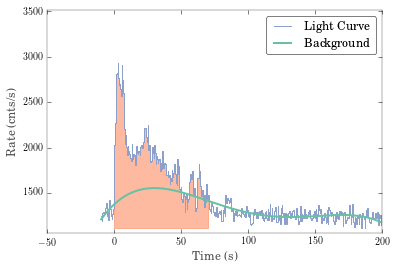

In [32]:
nai3.view_lightcurve(-10,200.,.5)

Oy! That is not so nice! Luckily, we can simply select another interval!

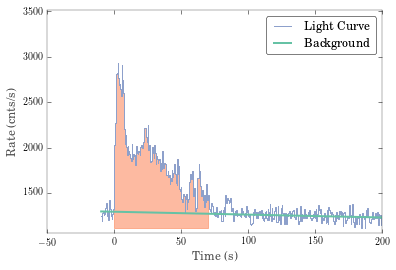

In [33]:
nai3.set_background_interval("-10.-0.","120-200") # You can select as many as required!
nai3.view_lightcurve(-10,200.,.5)

It is also possible to select multiple (disjoint only) src intervals

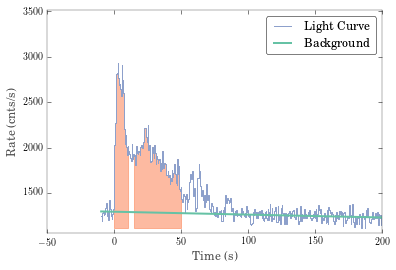

In [34]:
nai3.set_active_time_interval('0-10','15-50')

nai3.view_lightcurve(-10,200.,.5)

Selecting non-disjoint intervals will result in an error:

In [35]:
nai3.set_active_time_interval('0-10','5-50')

nai3.view_lightcurve(-10,200.,.5)

RuntimeError: Provided intervals are overlapping and hence invalid

In [36]:
# go back to our original selection
nai3.set_active_time_interval(src_selection)

Ok! This is a much better fit. If we change our source interval the counts are automatically recalculated.
### Energy selection

We need to select the energies we would like to fit over. GBM has over/underflow channels which must be exlcuded from the fit. This is not always at the same energy, so we need to check.
**FermiGBM_TTE_Like**  (and **FermiGBMLike** ) allow you to plot the count spectra so you can see what you will be excluding in the fit.

Range 10.0-30.0 translates to channels 6-21
Range 40.0-950.0 translates to channels 27-125
Now using 115 channels out of 128


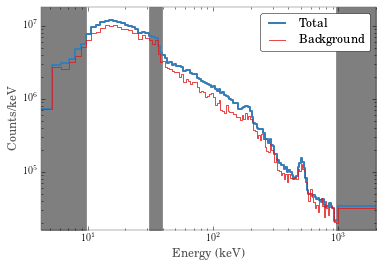

In [37]:
nai3.set_active_measurements("10.0-30.0", "40.0-950.0")
nai3.view_count_spectrum()

Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128


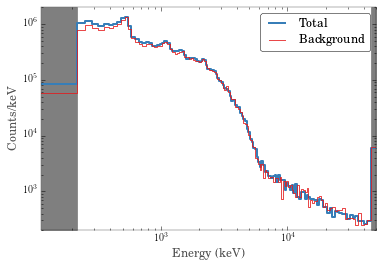

In [38]:
bgo0.set_active_measurements("250-43000")
bgo0.view_count_spectrum()

## Fitting!

We are now ready for the standard **3ML** process:


In [39]:
triggerName = 'bn080916009'
ra = 121.8
dec = -61.3


data_list = DataList(nai3,bgo0 )

band = Band()


GRB = PointSource( triggerName, ra, dec, spectral_shape=band )

model = Model( GRB )

model.display()

name,value,min_value,max_value,unit,delta,free
bn080916009.spectrum.main.Band.K,0.0001,None,None,1 / (cm2 keV s),1e-05,True
bn080916009.spectrum.main.Band.alpha,-1.0,-1.5,3.0,,0.1,True
bn080916009.spectrum.main.Band.xp,500.0,10.0,None,keV,50.0,True
bn080916009.spectrum.main.Band.beta,-2.0,-5.0,-1.6,,0.2,True


In [40]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn080916009.spectrum.main.Band.K,40 +/- 5,1 / (cm2 keV s)
1,bn080916009.spectrum.main.Band.alpha,-1.03 +/- 0.14,
2,bn080916009.spectrum.main.Band.xp,(1.6 +/- 1.6)e+03,keV
3,bn080916009.spectrum.main.Band.beta,-2.5 +/- 0.9,



NOTE: errors on parameters are approximate. Use get_errors().

(no nuisance parameters)

Correlation matrix:



1.00,0.96,-0.99,0.95
0.96,1.00,-0.99,0.95
-0.99,-0.99,1.00,-0.97
0.95,0.95,-0.97,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,5366.696904
NAI3,2549.956979
BGO0,2816.739925


In [41]:
res = jl.get_errors()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,39.7 -1.7 +2.0,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.03 -0.05 +0.05,
bn080916009.spectrum.main.Band.xp,(1.6 -0.4 +0.6)e+03,keV
bn080916009.spectrum.main.Band.beta,-2.5 -0.6 +0.26,


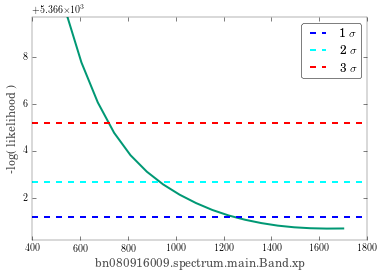

In [42]:
res = jl.get_contours(band.xp,400,1700,20)

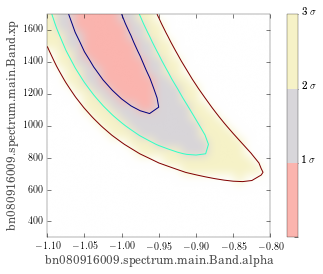

In [43]:
res = jl.get_contours(band.xp,300,1700,25,band.alpha,-1.1,-0.8,25)

## And if you really want to be sure => Go Bayesian!

In [47]:
# First define priors
# We can do it explicitly like this:
# (be careful not to choose the boundaries outside of the allowed value
# for the parameter, according to the min_value and max_value properties)

band.K.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=1e2)
band.xp.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)

# or use the set_uninformative_prior method, which will use as lower_bound
# and upper_bound the current boundaries for the parameter. Such boundaries
# must exists and be finite

band.alpha.set_uninformative_prior(Uniform_prior)
band.beta.set_uninformative_prior(Uniform_prior)

bayes = BayesianAnalysis(model, data_list)

### Sample with Affine Invariant Sampling

In [48]:
samples = bayes.sample(n_walkers=50,burn_in=200, n_samples=1000)

Running burn-in of 200 samples...


Sampling...


Mean acceptance fraction: 0.5141


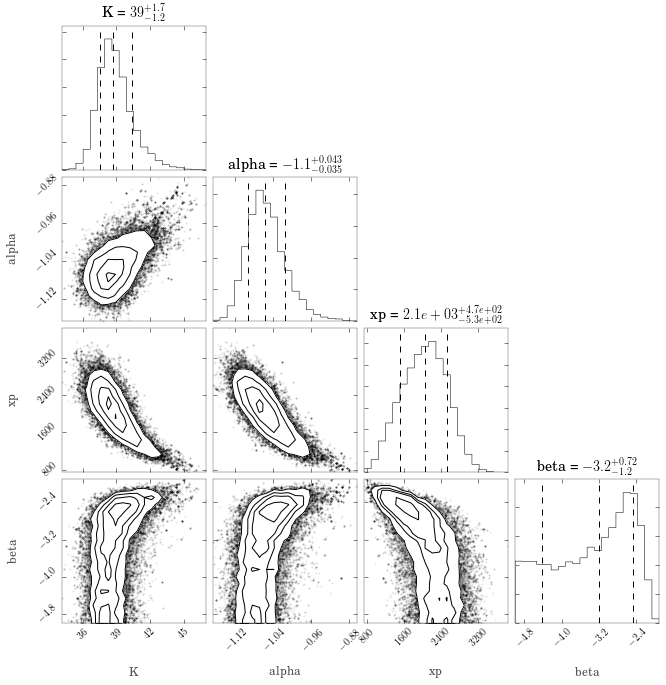

In [49]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

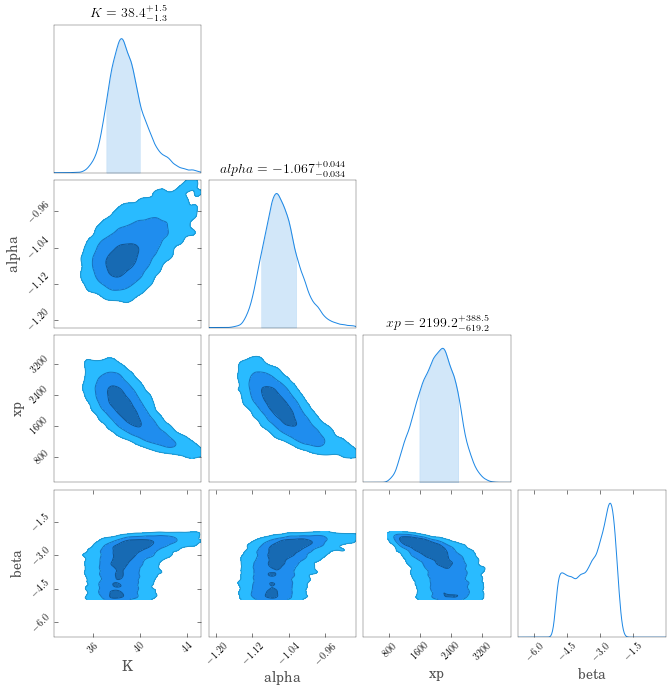

In [50]:
fig = bayes.corner_plot_cc()

In [51]:
band_bb = Band() + Blackbody()


GRB2 = PointSource( triggerName, ra, dec, spectral_shape=band_bb )

model2 = Model( GRB2 )


band_bb.K_1.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=1E2)
band_bb.xp_1.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)

# or use the set_uninformative_prior method, which will use as lower_bound
# and upper_bound the current boundaries for the parameter. Such boundaries
# must exists and be finite

band_bb.alpha_1.set_uninformative_prior(Uniform_prior)
band_bb.beta_1.set_uninformative_prior(Uniform_prior)

band_bb.K_2.prior = Log_uniform_prior(lower_bound=1e-6, upper_bound=3)
band_bb.kT_2.prior = Log_uniform_prior(lower_bound=10, upper_bound=500)
bayes2 = BayesianAnalysis(model2, data_list)

bayes2.sample(n_walkers=50,burn_in=200, n_samples=1000)

Running burn-in of 200 samples...


Sampling...


Mean acceptance fraction: 0.43746


OrderedDict([('bn080916009.spectrum.main.composite.K_1',
              array([  2.36514045e-04,   2.36514045e-04,   2.16035848e-04, ...,
                       8.03119908e-01,   7.80537613e-01,   9.37992264e-01])),
             ('bn080916009.spectrum.main.composite.alpha_1',
              array([ 1.8508582 ,  1.8508582 ,  2.24251051, ...,  2.44628075,
                      2.40982229,  2.53262144])),
             ('bn080916009.spectrum.main.composite.xp_1',
              array([  351.0941704 ,   351.0941704 ,   309.68436539, ...,  1019.30943022,
                      1042.66191283,   962.26319543])),
             ('bn080916009.spectrum.main.composite.beta_1',
              array([-2.6172962 , -2.6172962 , -2.72081867, ..., -2.2921479 ,
                     -2.23529253, -2.38675875])),
             ('bn080916009.spectrum.main.composite.K_2',
              array([ 0.0012159 ,  0.0012159 ,  0.0011816 , ...,  0.05389852,
                      0.05539066,  0.05794858])),
             ('bn08

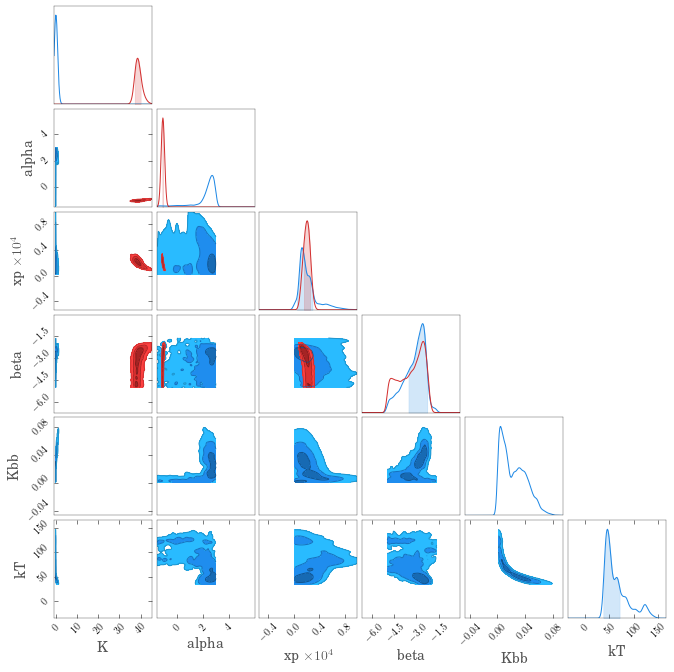

In [52]:
fig = bayes2.compare_posterior(bayes,renamed_parameters={'K_1':'K','alpha_1':'alpha','xp_1':'xp','beta_1':'beta','K_2':'Kbb','kT_2':'kT'})

### Sample with Nested Sampling (MULTINEST)

(see parallel demo for tips on parallel sampling with MPI)

In [53]:
samples = bayes.sample_multinest(n_live_points=400,resume=False)


Sampling...

MULTINEST has its own convergence criteria... you will have to wait blindly for it to finish
If INS is enabled, one can monitor the likelihood in the terminal for completion information
  analysing data from chains/fit-.txt


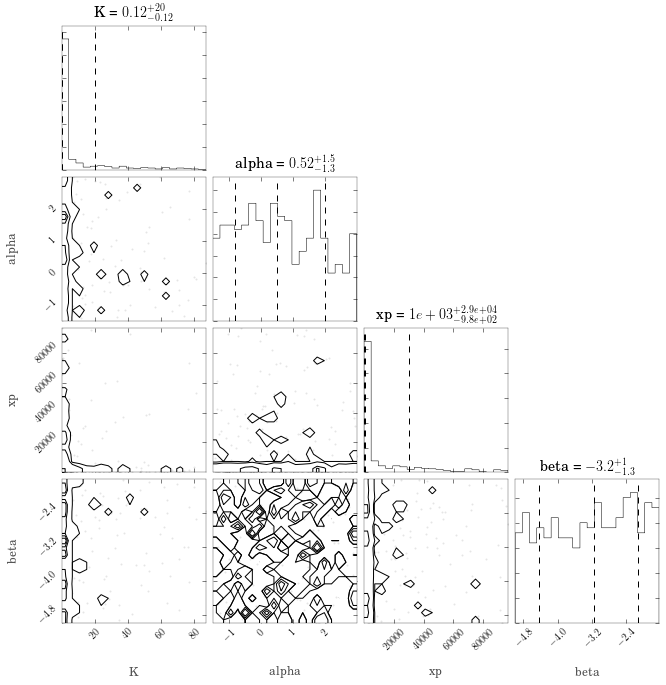

In [54]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

#### Credible Regions

In [24]:
# equal-tailed credible regions
eq_tail = bayes.get_credible_intervals()


Name,Value,Unit
bn080916009.spectrum.main.Band.K,2.659 -0.031 +0.035,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.930 -0.012 +0.013,
bn080916009.spectrum.main.Band.xp,(8.6 -0.4 +0.4)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.13 -0.04 +0.032,



(probability 68)


In [25]:
# highest denisty intervals
hdi = bayes.get_highest_density_interval()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,2.66 -0.14 +0.14,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.93 -0.05 +0.05,
bn080916009.spectrum.main.Band.xp,(8.6 -1.5 +2.0)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.13 -0.16 +0.12,


#### Effective free parameters (experimental)

Determine the complexity of your model and data 


In [26]:
bayes.get_effective_free_parameters()

3.9579152588503348

# TODO

* Export TTE selections to PHA files for XSPEC
* Handling RSP2 files correctly
* Your suggestions!